In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

#  The maximum setting: top K features： 48, WIN： 72, STEP： 288， limited on Nvidia RTX-2080ti (12G)
window = 72
step = 288
K = 48  # Number of features to keep

In [1]:
## Data processing 1
file1 = 'facility_1/facility_1_data_sm.csv'
file2 = 'facility_2/facility_2_data_sm.csv'

df1 = pl.read_csv(file1, infer_schema_length=1000000)
df2 = pl.read_csv(file2, infer_schema_length=1000000)

# Add a "coordinate" column to distinguish between the two datasets
df1 = df1.with_columns(pl.lit(True).alias("coordinate"))
df2 = df2.with_columns(pl.lit(False).alias("coordinate"))

# Find column differences between the two DataFrames
col1 = df1.columns
col2 = df2.columns
diff_df1_not_in_df2 = set(col1) - set(col2)
diff_df2_not_in_df1 = set(col2) - set(col1)

# Add missing columns with `None` values
for col in diff_df1_not_in_df2:
    if col != "coordinate":  # Skip the "coordinate" column
        df2 = df2.with_columns(pl.lit(None).alias(col))

for col in diff_df2_not_in_df1:
    if col != "coordinate":  # Skip the "coordinate" column
        df1 = df1.with_columns(pl.lit(None).alias(col))

# Align data types for common columns
common_columns = set(df1.columns) & set(df2.columns)

for col in common_columns:
    dtype1 = df1.schema[col]
    dtype2 = df2.schema[col]

    if dtype1 != dtype2:
        common_dtype = pl.Float64 if dtype1 == pl.Float64 or dtype2 == pl.Float64 else pl.Utf8
        if common_dtype == pl.Float64:
            df1 = df1.with_columns(
                pl.col(col)
                .map_elements(
                    lambda x: float(x) if str(x).replace('.', '', 1).isdigit() else None,
                    return_dtype=pl.Float64  # Specify return_dtype to avoid warnings
                )
                .alias(col)
            )
            df2 = df2.with_columns(
                pl.col(col)
                .map_elements(
                    lambda x: float(x) if str(x).replace('.', '', 1).isdigit() else None,
                    return_dtype=pl.Float64  # Specify return_dtype to avoid warnings
                )
                .alias(col)
            )

        df1 = df1.with_columns(pl.col(col).cast(common_dtype))
        df2 = df2.with_columns(pl.col(col).cast(common_dtype))

df = pl.concat([df1.select(common_columns), df2.select(common_columns)], how="vertical")

print(df.select(sorted(common_columns)).head(10))

shape: (10, 104)
┌────────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬──────┬───────────┐
│ bop_plc_ab ┆ bop_plc_ab ┆ bop_plc_ab ┆ bop_plc_ab ┆ … ┆ bop_plc_v ┆ coordinat ┆ rn   ┆ timestamp │
│ b_gc_commu ┆ b_gc_outle ┆ b_gc_outle ┆ b_gc_outle ┆   ┆ l_comp_vo ┆ e         ┆ ---  ┆ ---       │
│ nicationst ┆ tstream_ch ┆ tstream_co ┆ tstream_fl ┆   ┆ lumeslide ┆ ---       ┆ i64  ┆ str       │
│ …          ┆ …          ┆ …          ┆ …          ┆   ┆ _po…      ┆ bool      ┆      ┆           │
│ ---        ┆ ---        ┆ ---        ┆ ---        ┆   ┆ ---       ┆           ┆      ┆           │
│ bool       ┆ f64        ┆ f64        ┆ f64        ┆   ┆ f64       ┆           ┆      ┆           │
╞════════════╪════════════╪════════════╪════════════╪═══╪═══════════╪═══════════╪══════╪═══════════╡
│ true       ┆ 73.650002  ┆ 24.809999  ┆ 60.700001  ┆ … ┆ 70.434784 ┆ true      ┆ 300  ┆ 2023-03-3 │
│            ┆            ┆            ┆            ┆   ┆           ┆     

In [2]:
## Dataset processing 2

# 1. Handle boolean columns (convert to int32)
df = df.with_columns([
    pl.col(col).cast(pl.Int32).fill_null(0) if df[col].dtype == pl.Boolean else pl.col(col)
    for col in df.columns
])

# 2. Replace 'NULL' strings and handle string columns
df = df.with_columns([
    pl.when(pl.col(col) == "NULL")
    .then(None)
    .otherwise(pl.col(col))
    .cast(pl.Categorical)
    .to_physical()
    .fill_null(-1)
    .alias(col)
    for col in df.columns if df[col].dtype == pl.Utf8
])

# 3. Enhanced null handling for numeric columns
for col in df.columns:
    dtype = df[col].dtype

    if dtype.is_numeric():
        if df[col].is_null().all():
            df = df.with_columns(pl.col(col).fill_null(0))
        else:
            median_val = df[col].median()
            df = df.with_columns(
                pl.col(col)
                .fill_null(median_val)
                .clip(float('-inf'), float('inf'))
            )

# 4. Final verification
null_sum = df.null_count().select(pl.sum_horizontal(pl.all())).item()
if null_sum > 0:
    raise ValueError("Null values remain in the DataFrame.")

inf_sum = df.select(pl.all().is_infinite().sum()).select(pl.sum_horizontal(pl.all())).item()
if inf_sum > 0:
    raise ValueError("Infinite values detected in the DataFrame.")

print("Success: No nulls or infinities in the DataFrame")


Success: No nulls or infinities in the DataFrame


<Figure size 1800x1000 with 0 Axes>

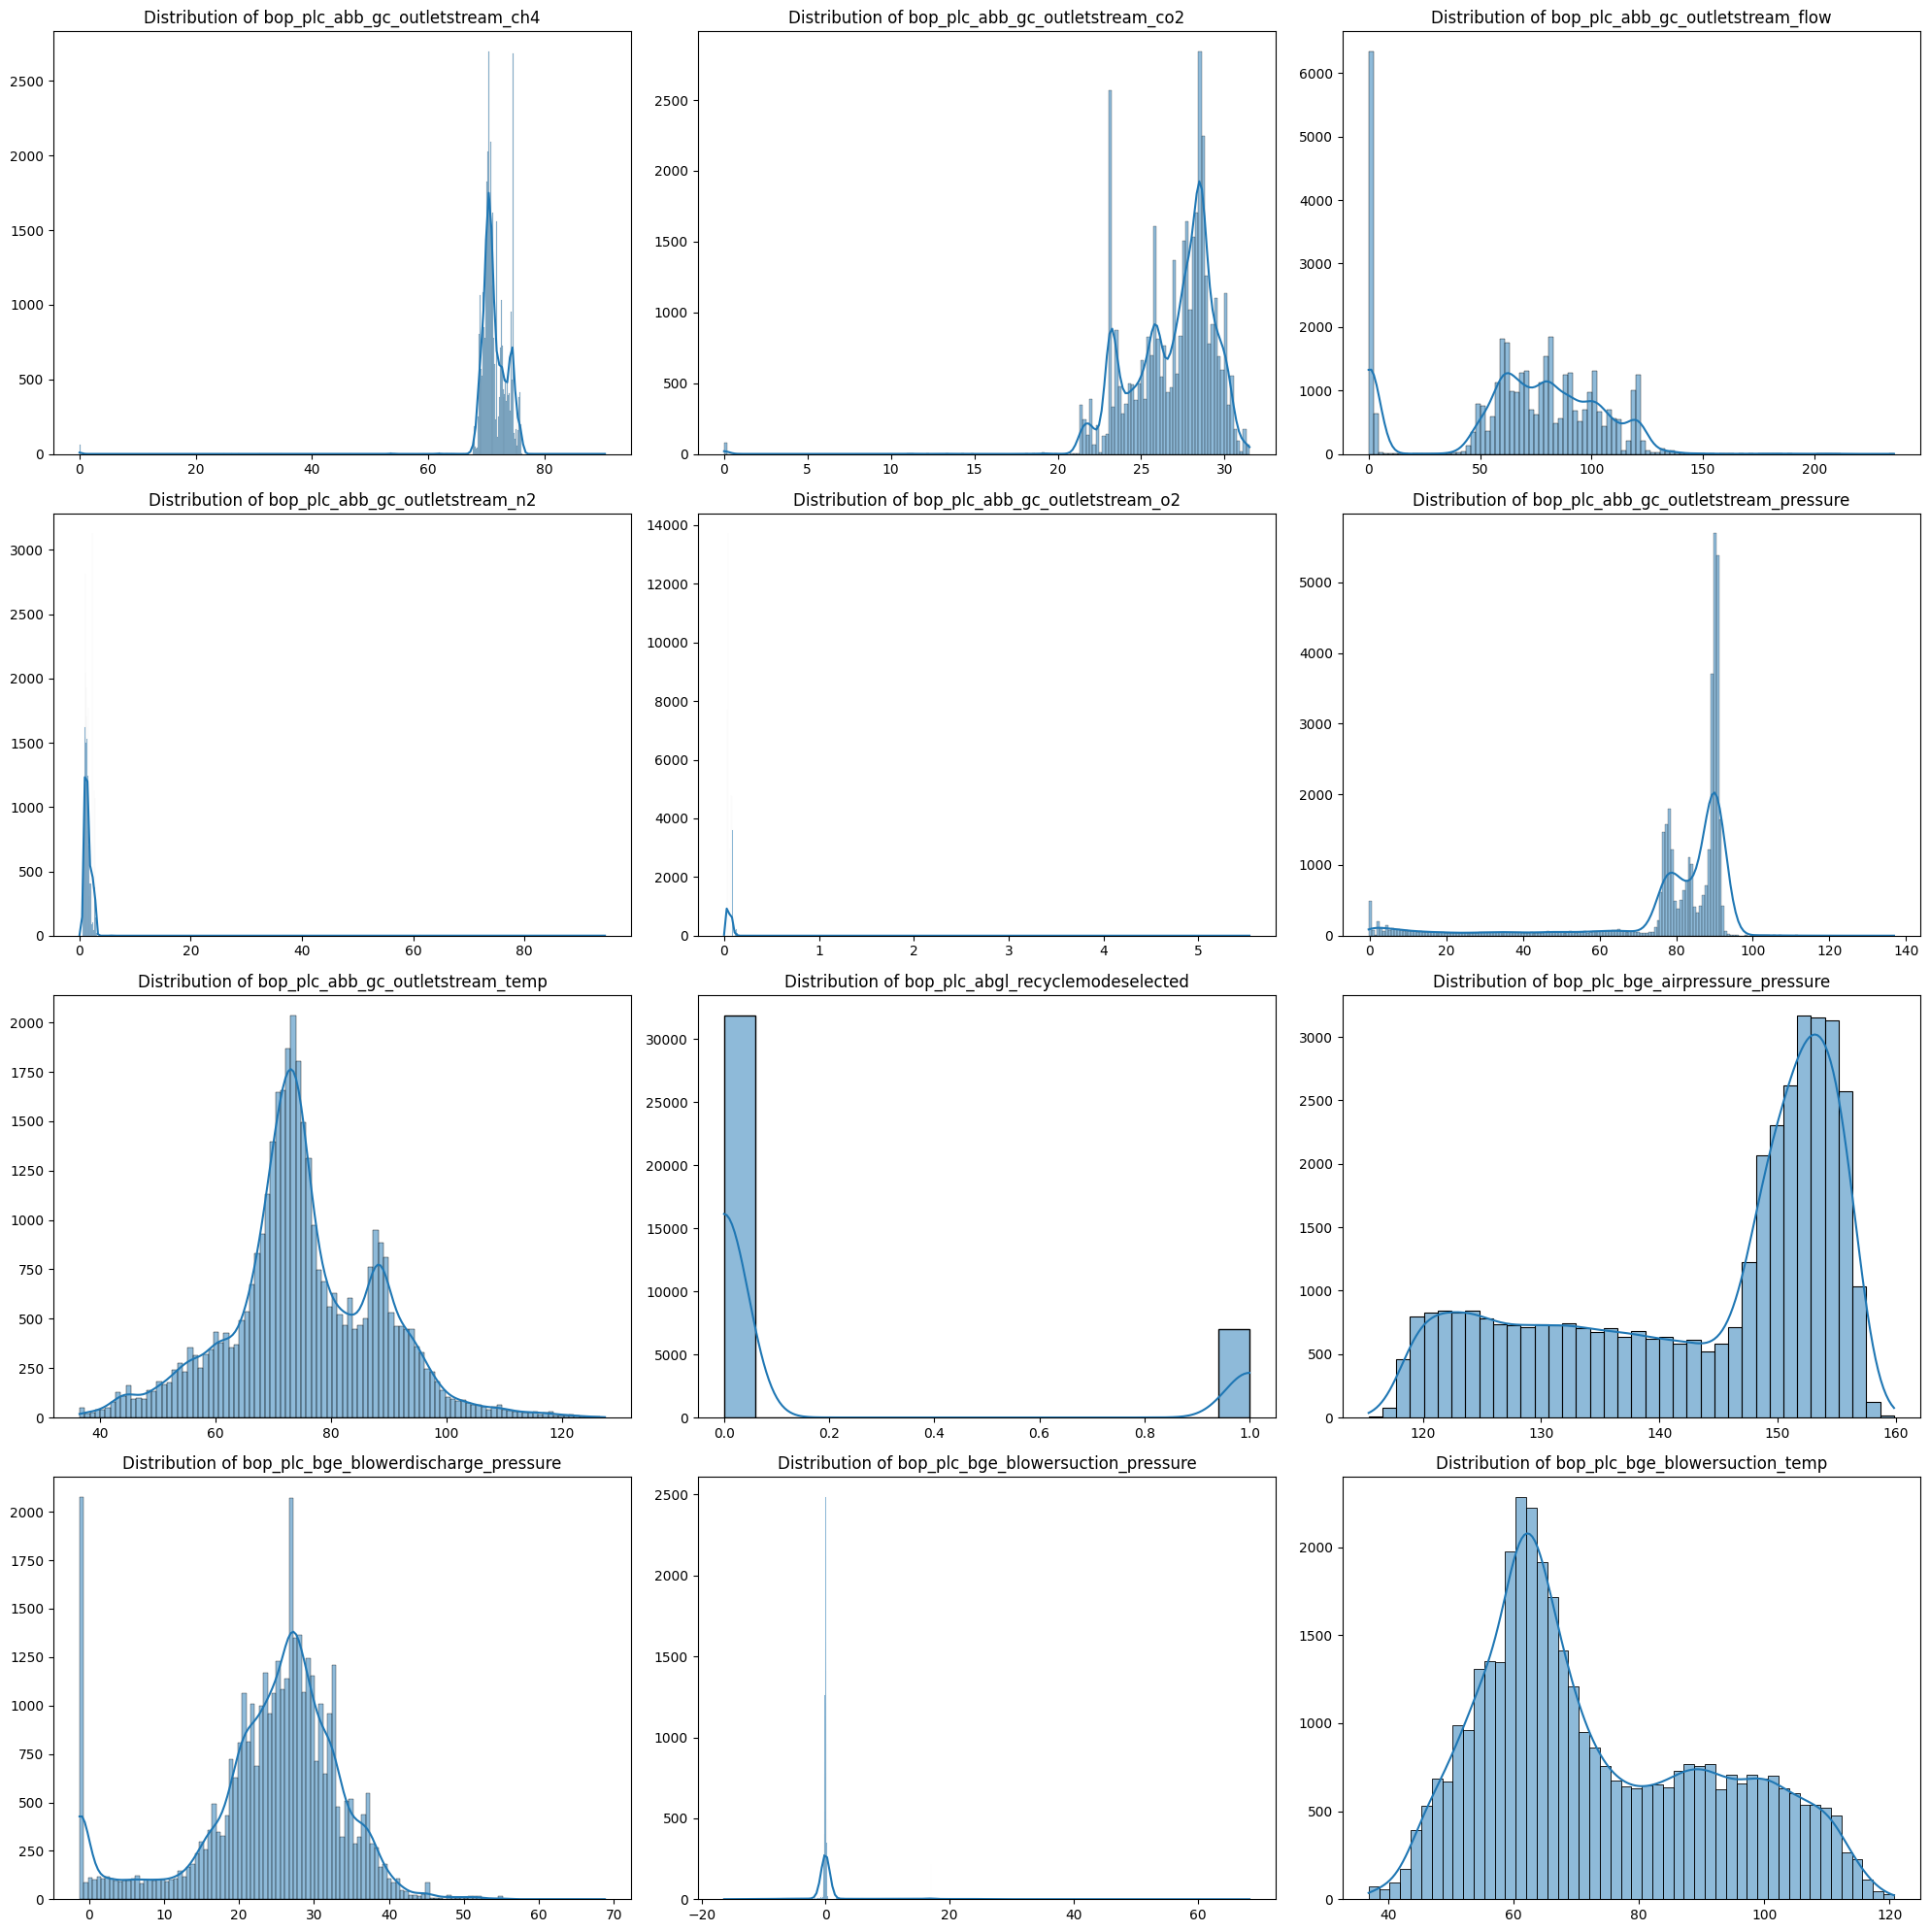

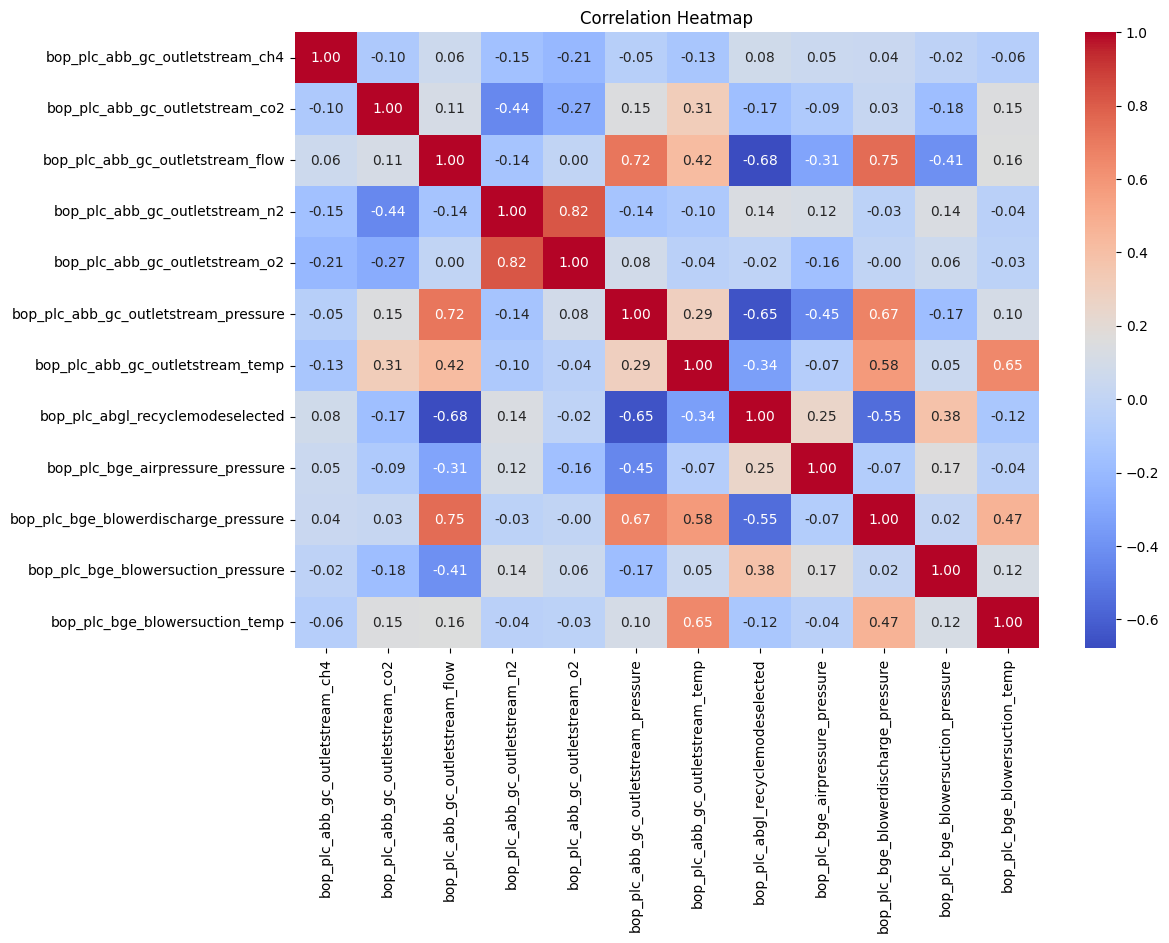

In [3]:
# Data visualization, picked up few main features
columns_to_visualize = [
    "bop_plc_abb_gc_outletstream_ch4",
    "bop_plc_abb_gc_outletstream_co2",
    "bop_plc_abb_gc_outletstream_flow",
    "bop_plc_abb_gc_outletstream_n2",
    "bop_plc_abb_gc_outletstream_o2",
    "bop_plc_abb_gc_outletstream_pressure",
    "bop_plc_abb_gc_outletstream_temp",
    "bop_plc_abgl_recyclemodeselected",
#     "bop_plc_bge_accumruntime",
    "bop_plc_bge_airpressure_pressure",
    "bop_plc_bge_blowerdischarge_pressure",
    "bop_plc_bge_blowersuction_pressure",
    "bop_plc_bge_blowersuction_temp"
]

df_filtered = df.select(columns_to_visualize)

plt.figure(figsize=(18, 10))
n_rows = 4
n_cols = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
axes = axes.flatten()

for i, column in enumerate(df_filtered.columns):
    if i < len(axes):
        sns.histplot(df_filtered[column].to_numpy(), kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {column}")
        axes[i].set_xlabel("")
        axes[i].set_ylabel("")

plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_filtered.to_pandas().corr()  # 计算相关性矩阵
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [4]:
# Label generation
methane_percentage = df["bop_plc_abb_gc_outletstream_ch4"]
flow_rate = df["bop_plc_abb_gc_outletstream_flow"]
is_running = df["bop_plc_bge_skid_running"]

duration_minutes = 5  # interval by samples is 5 minutes
norm_factor = 1000
# Calculate the energy output as label
energy_output = (
    flow_rate * duration_minutes *
    (methane_percentage / 100) *1010
    /norm_factor  ## to normalize
)

df = df.with_columns(
    energy_output.alias("energy_output")
)

# df = df.with_columns(
#     pl.when(is_running).then(energy_output).otherwise(pl.lit(None)).alias("energy_output")
# )

print(df.head())

shape: (5, 105)
┌────────────┬────────────┬───────────┬────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ bop_plc_vl ┆ bop_plc_vl ┆ bop_plc_c ┆ rn     ┆ … ┆ bop_plc_i ┆ bop_plc_a ┆ bop_plc_d ┆ energy_ou │
│ _comp_oili ┆ _comp_runs ┆ h800_chil ┆ ---    ┆   ┆ nr_fc_tod ┆ bb_gc_out ┆ ig_lev_po ┆ tput      │
│ njection_t ┆ tatus      ┆ ler_runcm ┆ f64    ┆   ┆ ayvolume_ ┆ letstream ┆ sition    ┆ ---       │
│ …          ┆ ---        ┆ d         ┆        ┆   ┆ mcf…      ┆ _pr…      ┆ ---       ┆ f64       │
│ ---        ┆ f64        ┆ ---       ┆        ┆   ┆ ---       ┆ ---       ┆ f64       ┆           │
│ f64        ┆            ┆ f64       ┆        ┆   ┆ f64       ┆ f64       ┆           ┆           │
╞════════════╪════════════╪═══════════╪════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 195.992386 ┆ 1.0        ┆ 0.0       ┆ 300.0  ┆ … ┆ -1.0      ┆ 90.760002 ┆ -1.0      ┆ 225.76303 │
│            ┆            ┆           ┆        ┆   ┆           ┆           

In [5]:
# Feature selection 1 -  Feature to feature co-relationship analysis (Better than feature to label approach)
corr_matrix = df.select(pl.corr(pl.all(), pl.all())).fill_nan(0)
target = "energy_output"  
# K = 48  # Number of features to keep

top_features = (
    corr_matrix
    .with_columns(pl.all().name.prefix("corr_"))  # Add prefix to avoid name conflicts
    .melt(variable_name="feature", value_name="correlation")
    .filter(pl.col("feature") != f"corr_{target}")  # Exclude target's self-correlation
    .with_columns(
        pl.col("correlation").abs().alias("abs_corr"),
        pl.col("feature").str.replace("^corr_", "")
    )
    .sort("abs_corr", descending=True)
    .head(K)
    .get_column("feature")
    .to_list()
)

# Ensure 'bop_plc_bge_skid_running' is always included in the selected features
if "bop_plc_bge_skid_running" not in top_features:
    top_features.append("bop_plc_bge_skid_running")

# Select the target, top features, and ensure 'bop_plc_bge_skid_running' is included
df_selected = df.select([target] + top_features)

print(f"Selected features: {top_features}")
print(df_selected)

Selected features: ['bop_plc_vl_comp_oilinjection_temp', 'bop_plc_vl_comp_runstatus', 'rn', 'bop_plc_ahu900_aircomp_runcmd', 'bop_plc_bge_pipelinevalve_opencmd', 'bop_plc_bge_pipelinevalve_open', 'bop_plc_bge_airpressure_pressure', 'bop_plc_bge_h2soutlet_temp', 'bop_plc_bge_dscrubber_conddrainvalve_closed', 'bop_plc_vl_comp_suction_temp', 'bop_plc_bge_recyclevalve_open', 'bop_plc_vl_comp_discharge_temp', 'bop_plc_vl_comp_faultstatus', 'bop_plc_inr_fc_yestvolume_real', 'bop_plc_abb_gc_outletstream_n2', 'bop_plc_bge_sump_bottomsensor_level_ina', 'bop_plc_bge_blowervfd_runcmd', 'bop_plc_ch800_chiller_runtimer', 'bop_plc_bge_blowervfd_speed', 'bop_plc_abb_gc_outletstream_ch4', 'bop_plc_abb_gc_outletstream_o2', 'bop_plc_vl_comp_mainmotor_amps', 'bop_plc_bge_pv0109_valveposition', 'bop_plc_bge_sump_topsensor_level', 'bop_plc_vl_comp_oilcooleroutlet_temp', 'bop_plc_bge_dscrubber_level_inwc', 'bop_plc_ch800_chiller_runstatus', 'bop_plc_vl_comp_filterinlet_pressure', 'bop_plc_vl_comp_oilseperat

In [6]:
# # Feature selection 2 -  Feature to label co-relationship analysis
# # Keep "bop_plc_bge_skid_running" anyway

# # Compute correlation of each feature with the target
# target = "energy_output"
## K = 48 # Number of features to keep

# # Calculate correlation of each column with the target
# corr_with_target = (
#     df.select(
#         [pl.corr(pl.col(feature), pl.col(target)).alias(feature) for feature in df.columns if feature != target]
#     )
#     .melt(variable_name="feature", value_name="correlation")
#     .with_columns(pl.col("correlation").abs().alias("abs_corr"))  # Use absolute correlation
#     .sort("abs_corr", descending=True)  # Sort by absolute correlation (descending)
#     .head(K)  # Keep the top K features
#     .get_column("feature")  # Extract the feature names
#     .to_list()
# )

# # Ensure 'bop_plc_bge_skid_running' is always included in the selected features
# if "bop_plc_bge_skid_running" not in corr_with_target:
#     corr_with_target.append("bop_plc_bge_skid_running")

# # Select the target and the top K features
# df_selected = df.select([target] + corr_with_target)

# print(f"Selected features: {corr_with_target}")
# print(df_selected)

In [7]:
# Dataset generation


#  The maximum setting: top K features： 48, WIN： 72, STEP： 288， limited on Nvidia GTX-2080ti (12G)
# window = 72
# step = 288


def generate_time_series_samples_pl(df: pl.DataFrame, win: int, step: int, target='energy_output'):
    feature_cols = [col for col in df.columns if col != target]
    
    # Convert to numpy arrays
    features = df[feature_cols].to_numpy()
    targets = df[target].to_numpy()
    
    X = []
    y = []

    for i in range(len(features) - win - step + 1):
        x_window = features[i:i+win]  # Feature window
        y_label = targets[i+win+step-1]  # Future target value
        X.append(x_window)
        y.append(y_label)

    return np.array(X), np.array(y)

X, y = generate_time_series_samples_pl(df_selected, win=window, step=step, target ='energy_output')

# Remove the "timestamp" as feature
X_columns = df_selected.columns
if "timestamp" in X_columns:
    timestamp_column_idx = X_columns.index("timestamp")
    X = np.delete(X, timestamp_column_idx, axis=2)  # Remove timestamp column from feature set

# Check the types before converting to float32
print(f"X type before split: {X.dtype}, y type: {y.dtype}")

X = np.nan_to_num(X, nan=np.nan)  # Convert NaN to numeric value, e.g., zero or the mean
y = np.nan_to_num(y, nan=np.nan)  # Similarly handle NaN in y

X = X.astype(np.float32)  
y = y.astype(np.float32) 

# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Output data shapes for confirmation
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}, y_val shape: {y_val.shape}')

# Convert to PyTorch tensors and ensure the correct type (float32)
X_train_tensor = torch.tensor(X_train).float() 
X_val_tensor = torch.tensor(X_val).float()      
y_train_tensor = torch.tensor(y_train).float()
y_val_tensor = torch.tensor(y_val).float()

X type before split: float64, y type: float64
X_train shape: (30836, 72, 48), y_train shape: (30836,)
X_val shape: (7710, 72, 48), y_val shape: (7710,)


In [8]:
# Build the network

class GatedResidualNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.gate = nn.GLU()  # Gated Linear Unit
        self.norm = nn.LayerNorm(input_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.gate(torch.cat([out, out], dim=-1))
        return self.norm(x + out)

class SimpleAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.scale = d_model ** 0.5

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attn_weights = torch.softmax(Q @ K.transpose(-2, -1) / self.scale, dim=-1)
        return attn_weights @ V

class TFTBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.gated_res = GatedResidualNetwork(input_size, hidden_size)
        self.attn = SimpleAttention(input_size)
        self.output_proj = nn.Linear(input_size, 1)

    def forward(self, x):
        x = self.gated_res(x)
        x = self.attn(x)
        out = self.output_proj(x[:, -1, :])  # last timestep
        return out.squeeze()

class TFTRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64):
        super().__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.tft_block = TFTBlock(hidden_size, hidden_size)

    def forward(self, x):
        x = self.encoder(x)
        out = self.tft_block(x)
        return out

input_size = X_train.shape[2]  # number of feature
model = TFTRegressor(input_size=input_size)


Using device: cuda
Epoch [0/5000] | Train Loss: 77856.1953 | Val MSE: 78515.0078 | LR: 0.001000
Epoch [10/5000] | Train Loss: 76337.2969 | Val MSE: 76978.3203 | LR: 0.000993
Epoch [20/5000] | Train Loss: 74606.8594 | Val MSE: 75203.6328 | LR: 0.000973
Epoch [30/5000] | Train Loss: 72460.9297 | Val MSE: 72989.9688 | LR: 0.000942
Epoch [40/5000] | Train Loss: 69722.0234 | Val MSE: 70169.5547 | LR: 0.000900
Epoch [50/5000] | Train Loss: 66398.0547 | Val MSE: 66768.6328 | LR: 0.000848
Epoch [60/5000] | Train Loss: 62611.3242 | Val MSE: 62917.5195 | LR: 0.000788
Epoch [70/5000] | Train Loss: 58576.6523 | Val MSE: 58839.7227 | LR: 0.000720
Epoch [80/5000] | Train Loss: 54538.0195 | Val MSE: 54780.4844 | LR: 0.000647
Epoch [90/5000] | Train Loss: 50717.0156 | Val MSE: 50958.5625 | LR: 0.000570
Epoch [100/5000] | Train Loss: 47280.4258 | Val MSE: 47535.9805 | LR: 0.000492
Epoch [110/5000] | Train Loss: 44328.8789 | Val MSE: 44608.1406 | LR: 0.000414
Epoch [120/5000] | Train Loss: 41899.6133 | 

Epoch [1040/5000] | Train Loss: 11989.0439 | Val MSE: 11883.4258 | LR: 0.000100
Epoch [1050/5000] | Train Loss: 11984.5625 | Val MSE: 11878.8115 | LR: 0.000152
Epoch [1060/5000] | Train Loss: 11978.0254 | Val MSE: 11872.1250 | LR: 0.000212
Epoch [1070/5000] | Train Loss: 11969.2197 | Val MSE: 11863.1094 | LR: 0.000280
Epoch [1080/5000] | Train Loss: 11959.6748 | Val MSE: 11854.8350 | LR: 0.000353
Epoch [1090/5000] | Train Loss: 11944.9600 | Val MSE: 11860.6680 | LR: 0.000430
Epoch [1100/5000] | Train Loss: 11933.0674 | Val MSE: 11820.9297 | LR: 0.000508
Epoch [1110/5000] | Train Loss: 11916.6045 | Val MSE: 11806.0781 | LR: 0.000586
Epoch [1120/5000] | Train Loss: 11890.1670 | Val MSE: 11808.6934 | LR: 0.000662
Epoch [1130/5000] | Train Loss: 11893.3242 | Val MSE: 11808.7588 | LR: 0.000734
Epoch [1140/5000] | Train Loss: 11864.3613 | Val MSE: 11735.9189 | LR: 0.000800
Epoch [1150/5000] | Train Loss: 11831.9326 | Val MSE: 11719.5928 | LR: 0.000859
Epoch [1160/5000] | Train Loss: 11796.52

Epoch [2070/5000] | Train Loss: 10157.3896 | Val MSE: 10105.5625 | LR: 0.000720
Epoch [2080/5000] | Train Loss: 10099.1729 | Val MSE: 10055.8799 | LR: 0.000647
Epoch [2090/5000] | Train Loss: 10046.8838 | Val MSE: 10018.1689 | LR: 0.000570
Epoch [2100/5000] | Train Loss: 9997.5986 | Val MSE: 9944.7402 | LR: 0.000492
Epoch [2110/5000] | Train Loss: 9959.7949 | Val MSE: 9907.2207 | LR: 0.000414
Epoch [2120/5000] | Train Loss: 9923.7891 | Val MSE: 9877.6055 | LR: 0.000338
Epoch [2130/5000] | Train Loss: 9899.0557 | Val MSE: 9867.0088 | LR: 0.000266
Epoch [2140/5000] | Train Loss: 9887.3281 | Val MSE: 9848.6982 | LR: 0.000200
Epoch [2150/5000] | Train Loss: 9871.0654 | Val MSE: 9825.3750 | LR: 0.000141
Epoch [2160/5000] | Train Loss: 9857.3447 | Val MSE: 9816.1221 | LR: 0.000091
Epoch [2170/5000] | Train Loss: 9850.0615 | Val MSE: 9808.4717 | LR: 0.000051
Epoch [2180/5000] | Train Loss: 9846.2217 | Val MSE: 9805.3047 | LR: 0.000022
Epoch [2190/5000] | Train Loss: 9844.8418 | Val MSE: 9804.

Epoch [3120/5000] | Train Loss: 9271.9014 | Val MSE: 9148.2295 | LR: 0.000662
Epoch [3130/5000] | Train Loss: 9318.3096 | Val MSE: 9206.8037 | LR: 0.000734
Epoch [3140/5000] | Train Loss: 9252.9131 | Val MSE: 9478.1689 | LR: 0.000800
Epoch [3150/5000] | Train Loss: 9166.1338 | Val MSE: 9334.8730 | LR: 0.000859
Epoch [3160/5000] | Train Loss: 9831.1289 | Val MSE: 9506.3682 | LR: 0.000909
Epoch [3170/5000] | Train Loss: 9445.3877 | Val MSE: 9704.6123 | LR: 0.000949
Epoch [3180/5000] | Train Loss: 9310.2041 | Val MSE: 9563.9043 | LR: 0.000978
Epoch [3190/5000] | Train Loss: 9012.8994 | Val MSE: 9231.0557 | LR: 0.000995
Epoch [3200/5000] | Train Loss: 9093.2695 | Val MSE: 9316.9180 | LR: 0.001000
Epoch [3210/5000] | Train Loss: 8990.5322 | Val MSE: 9118.3672 | LR: 0.000993
Epoch [3220/5000] | Train Loss: 8903.7949 | Val MSE: 8991.6777 | LR: 0.000973
Epoch [3230/5000] | Train Loss: 9288.1865 | Val MSE: 9222.9434 | LR: 0.000942
Epoch [3240/5000] | Train Loss: 9057.9678 | Val MSE: 9225.4668 |

Epoch [4180/5000] | Train Loss: 8317.0381 | Val MSE: 8420.2090 | LR: 0.000022
Epoch [4190/5000] | Train Loss: 8316.6562 | Val MSE: 8421.3594 | LR: 0.000005
Epoch [4200/5000] | Train Loss: 8316.6006 | Val MSE: 8420.9590 | LR: 0.000000
Epoch [4210/5000] | Train Loss: 8316.5625 | Val MSE: 8420.8613 | LR: 0.000007
Epoch [4220/5000] | Train Loss: 8316.2852 | Val MSE: 8420.5176 | LR: 0.000027
Epoch [4230/5000] | Train Loss: 8315.5273 | Val MSE: 8419.8652 | LR: 0.000058
Epoch [4240/5000] | Train Loss: 8314.0938 | Val MSE: 8418.6416 | LR: 0.000100
Epoch [4250/5000] | Train Loss: 8311.8496 | Val MSE: 8416.4609 | LR: 0.000152
Epoch [4260/5000] | Train Loss: 8308.8008 | Val MSE: 8413.8193 | LR: 0.000212
Epoch [4270/5000] | Train Loss: 8304.8926 | Val MSE: 8410.0381 | LR: 0.000280
Epoch [4280/5000] | Train Loss: 8300.1592 | Val MSE: 8406.6055 | LR: 0.000353
Epoch [4290/5000] | Train Loss: 8313.1035 | Val MSE: 8444.5518 | LR: 0.000430
Epoch [4300/5000] | Train Loss: 8325.9854 | Val MSE: 8463.7178 |

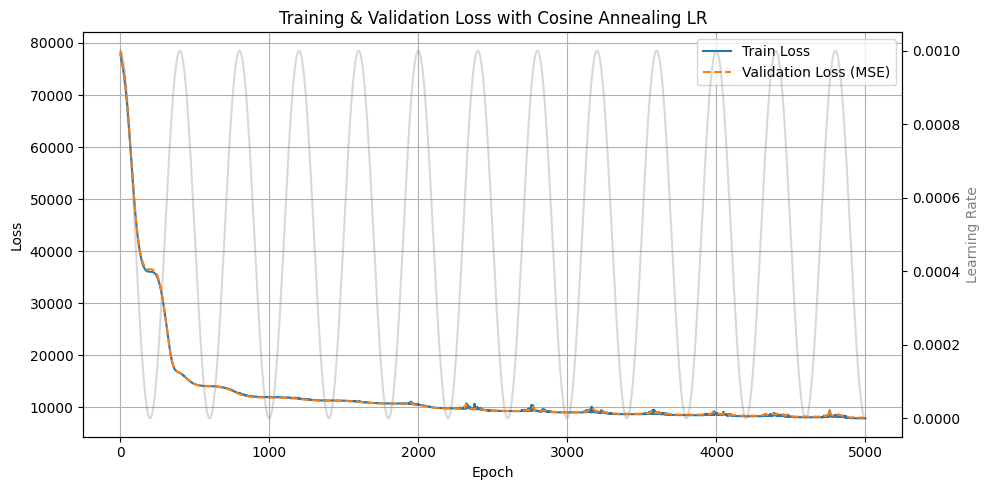

In [9]:
# Train and evaluate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model and data to device
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# Track losses
train_losses = []
val_losses = []
lr_schedule = []

# Training loop
epochs = 5000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()

    train_losses.append(loss.item())
    lr_schedule.append(optimizer.param_groups[0]['lr'])

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val_tensor)
            val_loss = mean_squared_error(y_val_tensor.cpu().numpy(), y_val_pred.cpu().numpy())
            val_losses.append(val_loss)
            print(f"Epoch [{epoch}/{epochs}] | Train Loss: {loss.item():.4f} | Val MSE: {val_loss:.4f} | LR: {lr_schedule[-1]:.6f}")

# Plot losses and LR
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(range(0, epochs, 10), val_losses, label='Validation Loss (MSE)', linestyle='--')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper right')
ax1.grid(True)

# Add LR plot
ax2 = ax1.twinx()
ax2.plot(lr_schedule, label='LR', color='gray', alpha=0.3)
ax2.set_ylabel('Learning Rate', color='gray')

plt.title('Training & Validation Loss with Cosine Annealing LR')
plt.tight_layout()
plt.show()


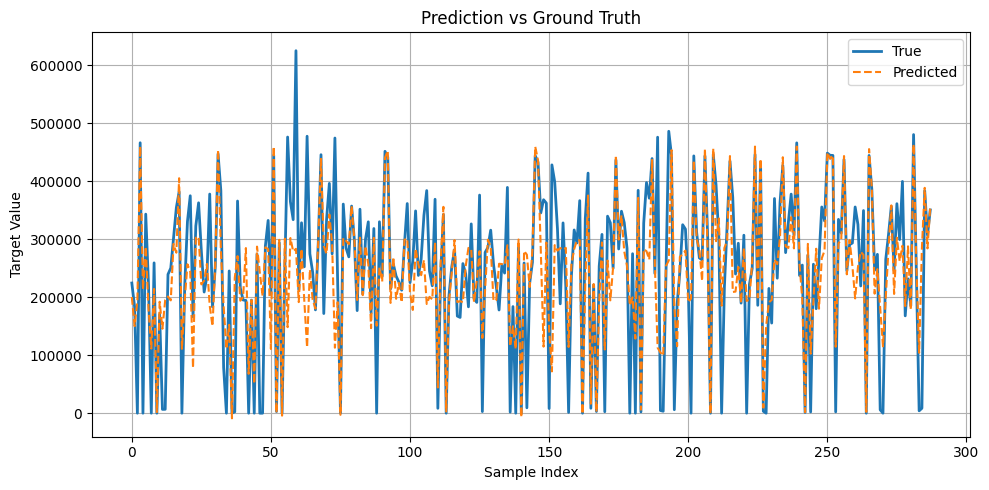

In [10]:
# Visualize the prediction
import matplotlib.pyplot as plt

# Denormalize to actual label value
y_true = y_val_tensor.cpu().numpy()[:288] * norm_factor
y_pred = y_val_pred.cpu().numpy()[:288] * norm_factor

# Plot: Predicted vs True
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='True', linewidth=2)
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title('Prediction vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# GPU memory release
import gc
gc.collect()
torch.cuda.empty_cache()